In [1]:
import numpy as np
import random

# Funções de avaliação
def f1(x):
    return (x - 2)**2

def f2(x):
    return (x + 2)**2

# Inicialização da população
def initialize_population(size, bounds):
    return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

# Avaliação
def evaluate_population(population):
    return [(f1(x), f2(x)) for x in population]

# Ordenação não-dominada eficiente
def fast_nondominated_sort(objectives):
    fronts = [[]]
    domination_count = [0] * len(objectives)
    dominated_solutions = [[] for _ in range(len(objectives))]
    ranks = [0] * len(objectives)

    for p in range(len(objectives)):
        for q in range(len(objectives)):
            if dominates(objectives[p], objectives[q]):
                dominated_solutions[p].append(q)
            elif dominates(objectives[q], objectives[p]):
                domination_count[p] += 1

        if domination_count[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in dominated_solutions[p]:
                domination_count[q] -= 1
                if domination_count[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    fronts.pop()
    return fronts, ranks

# Dominância
def dominates(obj1, obj2):
    return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

# Distância de crowding
def crowding_distance(front, objectives):
    if len(front) == 1:
        return [float('inf')]
    
    distances = [0] * len(front)
    for m in range(len(objectives[0])):
        sorted_front = sorted(range(len(front)), key=lambda i: objectives[front[i]][m])
        distances[sorted_front[0]] = distances[sorted_front[-1]] = float('inf')
        for i in range(1, len(front) - 1):
            distances[sorted_front[i]] += (
                objectives[front[sorted_front[i + 1]]][m] - objectives[front[sorted_front[i - 1]]][m]
            )
    return distances

# Seleção com elitismo
def select_next_population(fronts, objectives, population, pop_size):
    next_population = []
    for front in fronts:
        if len(next_population) + len(front) <= pop_size:
            next_population.extend(front)
        else:
            distances = crowding_distance(front, objectives)
            sorted_front = sorted(zip(front, distances), key=lambda x: x[1], reverse=True)
            next_population.extend([solution for solution, _ in sorted_front[:pop_size - len(next_population)]])
            break
    return [population[i] for i in next_population]  # Seleciona os indivíduos correspondentes

# Cruzamento
def crossover(parent1, parent2):
    return (parent1 + parent2) / 2

# Mutação
def mutation(individual, bounds, mutation_rate=0.5):
    if random.random() < mutation_rate:
        individual += random.uniform(-0.1, 0.1)
        individual = np.clip(individual, bounds[0], bounds[1])  # Garante que o valor permaneça nos limites
    return individual

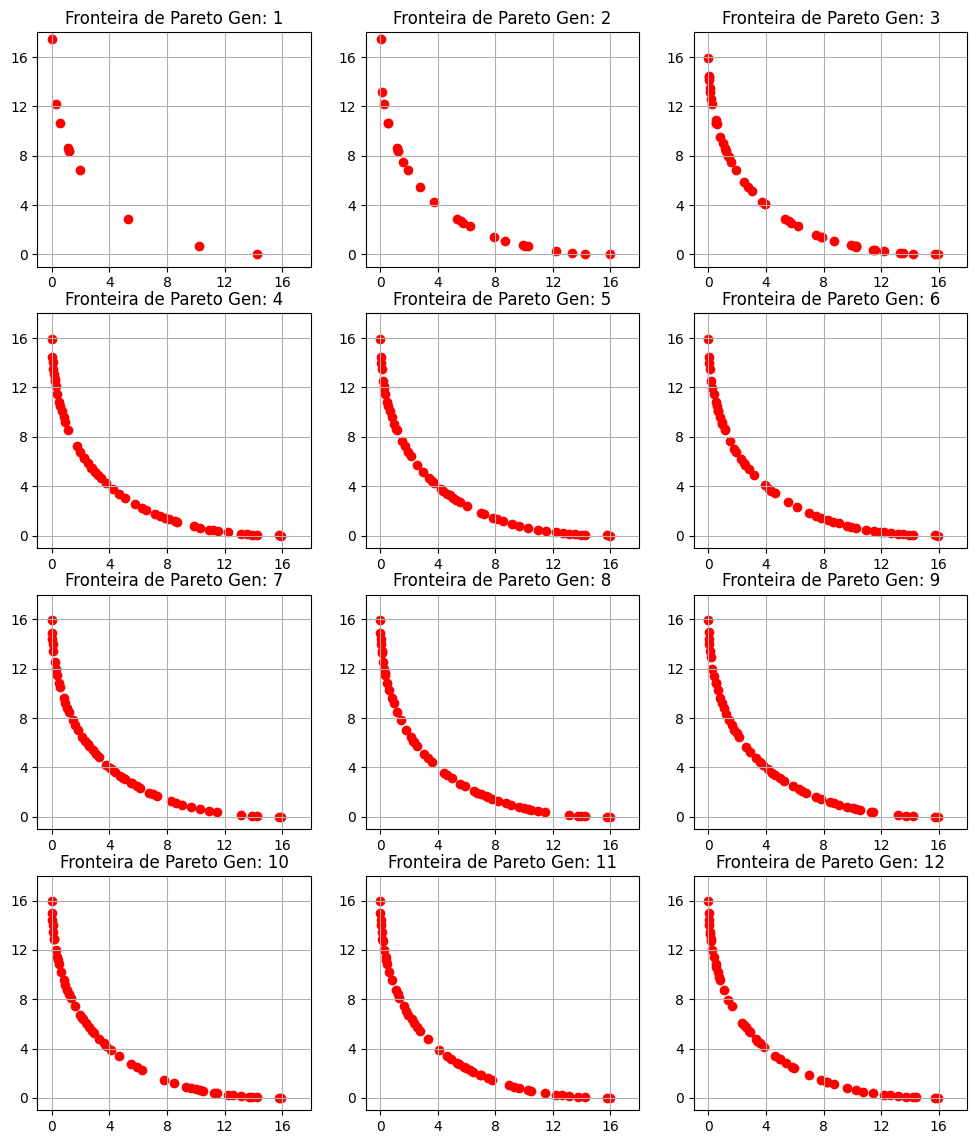

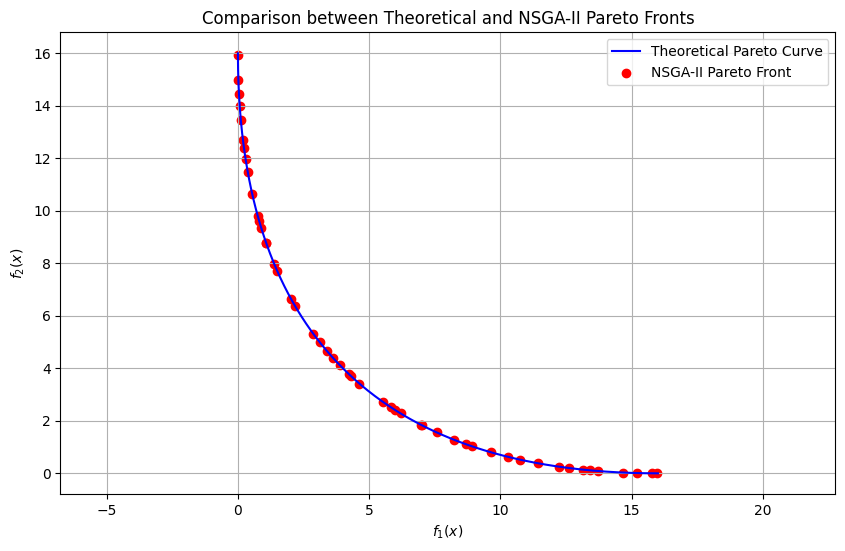

In [2]:
import matplotlib.pyplot as plt

pop_size=50
bounds=(-10, 10)
generations = 12
population = initialize_population(pop_size, bounds)

plt.figure(figsize=(12,14))

# Algoritmo NSGA-II
for gen in range(generations):
    # Avaliar a nova população
    objectives = evaluate_population(population)
    fronts, _ = fast_nondominated_sort(objectives)

    # Fronteira de Pareto no espaço de objetivos
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()
    plt.subplot(4, 3, gen+1)
    plt.scatter(*zip(*pareto_front), label="Fronteira de Pareto NSGA", color="red")
    plt.title(f"Fronteira de Pareto Gen: {gen+1}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])

    # Criar descendentes usando operadores genéticos
    offspring = []
    while len(offspring) < pop_size:
        parent1, parent2 = random.sample(population, 2)
        
        child = crossover(parent1, parent2)

        child = mutation(child, bounds)
        
        offspring.append(child)
        
    # Combinar pais e descendentes
    combined_population = population + offspring
    combined_objectives = evaluate_population(combined_population)
    
    # Realizar nova ordenação não-dominada
    combined_fronts, _ = fast_nondominated_sort(combined_objectives)
    
    # Selecionar próxima geração com elitismo
    population = select_next_population(combined_fronts, combined_objectives, combined_population, pop_size)

# Final evaluation
objectives = evaluate_population(population)
fronts, _ = fast_nondominated_sort(objectives)
pareto_front = [objectives[i] for i in fronts[0]]
pareto_front.sort()

# Theoretical Pareto curve
x_theoretical = np.linspace(-2, 2, 500)
f1_theoretical = f1(x_theoretical)
f2_theoretical = f2(x_theoretical)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(f1_theoretical, f2_theoretical, label="Theoretical Pareto Curve", color="blue")
plt.scatter(*zip(*pareto_front), label="NSGA-II Pareto Front", color="red")
plt.title("Comparison between Theoretical and NSGA-II Pareto Fronts")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.legend()
plt.axis("equal")
plt.grid()
plt.show()
